In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#make meta data, remove null label

In [ ]:
import os
import pandas as pd

CSV_FILE_PATH = '/content/drive/MyDrive/PhotoQA/images_data_filtered.csv'
IMAGE_DIR = '/content/drive/MyDrive/PhotoQA/cropdata'

df = pd.read_csv(CSV_FILE_PATH)

def clean_and_check_image_data(df, image_dir):
    # 데이터프레임에 있는 이미지 경로를 기준으로 실제 존재 여부를 확인
    valid_data = []
    missing_in_metadata = []

    # 1. 메타데이터 기준으로 실제 이미지 파일을 체크
    for idx, row in df.iterrows():
        job_no = str(row["job_no"])
        image_name = row["image_name"]
        image_path = os.path.join(image_dir, job_no, image_name)

        # 이미지가 존재하는 경우만 valid_data 리스트에 추가
        if os.path.exists(image_path):
            valid_data.append(row)
        else:
            print(f"Image missing: {image_path}")

    # 2. 데이터프레임으로 유효한 데이터만 유지
    cleaned_df = pd.DataFrame(valid_data)

    # # 3. 폴더를 순회하여 메타데이터에 없는 이미지 파일을 확인
    # for job_folder in os.listdir(image_dir):
    #     job_folder_path = os.path.join(image_dir, job_folder)

    #     # job_folder가 실제 폴더일 때만 진행
    #     if os.path.isdir(job_folder_path):
    #         for image_name in os.listdir(job_folder_path):
    #             image_path = os.path.join(job_folder_path, image_name)

    #             # 현재 이미지가 메타데이터에 있는지 확인
    #             if not ((cleaned_df["job_no"] == job_folder) & (cleaned_df["image_name"] == image_name)).any():
    #                 print(f"Image not in metadata: {image_path}")
    #                 missing_in_metadata.append(image_path)

    return cleaned_df


In [ ]:

df2 = clean_and_check_image_data(df, IMAGE_DIR)

Image missing: /content/drive/MyDrive/PhotoQA/cropdata/790804/Image.png
Image missing: /content/drive/MyDrive/PhotoQA/cropdata/788420/710376987-smokealarm-bedroom-4.jpeg
Image missing: /content/drive/MyDrive/PhotoQA/cropdata/788420/710377033-smokealarm-bedroom-5.jpeg
Image missing: /content/drive/MyDrive/PhotoQA/cropdata/757249/Screenshot-2024-02-06-140415.png
Image missing: /content/drive/MyDrive/PhotoQA/cropdata/754699/Screenshot-2024-04-18-135132.png
Image missing: /content/drive/MyDrive/PhotoQA/cropdata/754699/Screenshot-2024-04-18-135048.png


In [ ]:
print(len(df),len(df2))

4294 4288


In [ ]:
df = df2
df.to_csv('/content/drive/MyDrive/PhotoQA/remove_null_only_expiry.csv', index = False)

#import library

In [3]:
import cv2
import os
import pandas as pd
import torch
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm  # Import tqdm for the progress bar
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import average_precision_score



os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.cuda.empty_cache()
from torch.utils.data import WeightedRandomSampler # for data augmentation


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


#Common.py: including configuration, seed_everything

In [4]:
# Paths
CSV_FILE_PATH = '/content/drive/MyDrive/PhotoQA/remove_null_only_expiry.csv'
IMAGE_DIR = '/content/drive/MyDrive/PhotoQA/cropdata'

#Image resolution
IMG_SIZE = 456

# DataLoader settings
BATCH_SIZE = 16
# Training settings
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3 #3e-4 #0.001 -> 0.0003

# Normalization parameters for pretrained models
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

#data.py

In [5]:
# Define a PyTorch Dataset
class SmokeAlarmDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = {"Approved": 1, "Declined": 0}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get job number and image name
        job_no = str(self.df.iloc[idx]["job_no"])
        image_name = self.df.iloc[idx]["image_name"]

        # Map the label
        label = self.df.iloc[idx]["image_status"]
        label = self.label_map.get(label, 0)

        # Construct image path and load the image
        image_path = os.path.join(self.image_dir, job_no, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Apply transform if available
        if self.transform:
            image = self.transform(image=image)["image"]

        # Return image and label
        return image, label


#model.py

In [6]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b5(pretrained=True)  # pretrained 대신 weights 사용

        # EfficientNet의 출력층을 클래스 수에 맞게 수정
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(self.backbone.classifier[1].in_features, 1)
        )

    def forward(self, x):
        return self.backbone(x)

#train.py

In [12]:
train_transform = A.Compose([

        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean = NORMALIZE_MEAN, std = NORMALIZE_STD,
                    max_pixel_value= 255.0, always_apply=False, p = 1.0), #normalization
        ToTensorV2()

])

test_transform = A.Compose([

        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean = NORMALIZE_MEAN, std = NORMALIZE_STD,
                    max_pixel_value= 255.0, always_apply=False, p = 1.0), #normalization
        ToTensorV2()

])
df = pd.read_csv(CSV_FILE_PATH)
#adding weight
num_declined = (df['image_status'] == 'Declined').sum()  # Declined 클래스 수
num_approved = (df['image_status'] == 'Approved').sum()  # Approved 클래스 수
pos_weight = torch.tensor([num_approved / num_declined], dtype=torch.float).to(DEVICE)


criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

#get rid of sampler(adding weight to prevent overfitting)
def load_data(df, image_dir, train_transform, test_transform, batch_size):

    # Split data into train, validation, and test sets
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['image_status'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['image_status'])

    # Initialize datasets
    train_dataset = SmokeAlarmDataset(train_df, image_dir, transform=train_transform)
    val_dataset = SmokeAlarmDataset(val_df, image_dir, transform=test_transform)
    test_dataset = SmokeAlarmDataset(test_df, image_dir, transform=test_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # return train_loader, val_loader, test_loader, le
    return train_loader, val_loader, test_loader, train_df, val_df, test_df


def train(model, train_loader, val_loader, criterion, optimizer, scheduler, DEVICE):
    model.to(DEVICE)
    best_score = 0
    best_model = None
    train_losses = []
    train_mAPs = []
    val_losses = []
    val_mAPs = []
    all_train_labels = []  # 모든 에포크의 train true_labels를 저장
    all_train_probs = []   # 모든 에포크의 train predictions_prob를 저장
    all_val_labels = []    # 모든 에포크의 val true_labels를 저장
    all_val_probs = []     # 모든 에포크의 val predictions_prob를 저장

    for epoch in range(NUM_EPOCHS):
        model.train()
        batch_losses = []
        true_labels = []
        predictions_prob = []

        # Training Loop
        for img, label in tqdm(iter(train_loader), desc=f"Training Epoch {epoch + 1}/{NUM_EPOCHS}"):
            label = label = label.float()
            img, label = img.float().to(DEVICE), label.to(DEVICE)

            optimizer.zero_grad()
            pred = model(img)
            loss = criterion(pred, label.unsqueeze(1))
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            # 예측값과 실제값 저장
            true_labels += label.int().cpu().numpy().flatten().tolist()
            predictions_prob += pred.sigmoid().detach().cpu().numpy().flatten().tolist()

        # Calculate the average training loss for this epoch
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)

        # mAP 계산
        train_mAP = average_precision_score(true_labels, predictions_prob)
        train_mAPs.append(train_mAP)

        # 현재 에포크의 train true_labels와 predictions_prob 저장
        all_train_labels.append(true_labels)
        all_train_probs.append(predictions_prob)

        # Validation step
        val_results = validation(model, criterion, val_loader, DEVICE)
        val_losses.append(val_results["val_loss"])
        val_mAPs.append(val_results["val_mAP"])

        # 검증 데이터의 true_labels와 predictions_prob 저장
        all_val_labels.append(val_results["true_labels"])
        all_val_probs.append(val_results["predictions_prob"])

        # 현재 에포크 결과 출력
        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.5f}, Train mAP: {train_mAP:.5f}, "
              f"Val Loss: {val_results['val_loss']:.5f}, Val mAP: {val_results['val_mAP']:.5f}")

        # 최고 성능 모델 저장
        if val_results["val_mAP"] > best_score:
            best_score = val_results["val_mAP"]
            best_model = model.state_dict()  # Save model weights

        if scheduler:
            scheduler.step()

    return train_losses, train_mAPs, val_losses, val_mAPs, all_train_labels, all_train_probs, all_val_labels, all_val_probs, best_model

# 수정된 validation 함수에서 DEVICE 적용
def validation(model, criterion, val_loader, DEVICE):
    model.eval()
    model_pred = []
    true_labels = []
    val_loss = []
    predictions_prob = []

    with torch.no_grad():
        for img, label in tqdm(iter(val_loader)):
            label = label.type(torch.FloatTensor)
            img, label = img.float().to(DEVICE), label.to(DEVICE)

            pred = model(img)
            loss = criterion(pred, label.unsqueeze(1))

            val_loss.append(loss.item())

            predictions_prob += pred.sigmoid().detach().cpu().numpy().flatten().tolist()
            model_pred += (pred.sigmoid() > 0.5).int().cpu().numpy().flatten().tolist() #model_pred += pred.argmax(1).detach().cpu().numpy().tolist() << multy classfication
            true_labels += label.detach().cpu().numpy().tolist()

    avg_val_loss = np.mean(val_loss)
    val_mAP = average_precision_score(true_labels, predictions_prob)

    return {
        "val_loss": avg_val_loss,
        "val_mAP": val_mAP,
        "true_labels": true_labels,          # PR Curve를 위한 true_labels 반환
        "predictions_prob": predictions_prob  # PR Curve를 위한 predictions_prob 반환
    }


#Find out proportion in different category

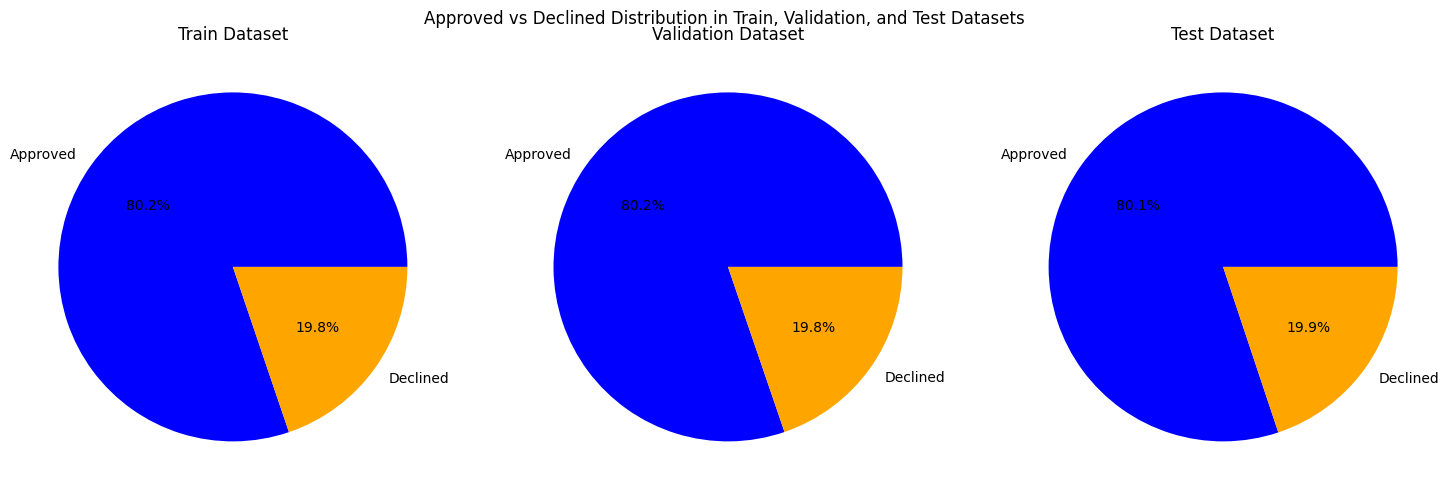

In [13]:
import matplotlib.pyplot as plt

# def load_train_data(df, image_dir, train_transform, test_transform, batch_size):

train_loader, val_loader, test_loader, train_df, val_df, test_df = load_data(df,IMAGE_DIR,train_transform,test_transform,BATCH_SIZE)

# Count approved and declined samples in each dataset
train_counts = train_df['image_status'].value_counts()
val_counts = val_df['image_status'].value_counts()
test_counts = test_df['image_status'].value_counts()

# Plot the counts for each dataset as pie charts
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Train set
axs[0].pie(train_counts, labels=['Approved', 'Declined'], autopct='%1.1f%%', colors=['blue', 'orange'])
axs[0].set_title("Train Dataset")

# Validation set
axs[1].pie(val_counts, labels=['Approved', 'Declined'], autopct='%1.1f%%', colors=['blue', 'orange'])
axs[1].set_title("Validation Dataset")

# Test set
axs[2].pie(test_counts, labels=['Approved', 'Declined'], autopct='%1.1f%%', colors=['blue', 'orange'])
axs[2].set_title("Test Dataset")

plt.suptitle("Approved vs Declined Distribution in Train, Validation, and Test Datasets")
plt.tight_layout()
plt.show()

#train.py

In [14]:
  #  if __name__ == '__main__':
    # print(train_df.head())
# df = pd.read_csv(CSV_FILE_PATH)

# # def load_train_data(df, image_dir, train_transform, test_transform, batch_size):

# train_loader, val_loader, test_loader = load_data(df,IMAGE_DIR,train_transform,test_transform,BATCH_SIZE)

seed_everything(seed= 42)

model = BaseModel()

optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)#lr=1e-3

scheduler = None # i also remove it

# Train the model with the correct argument order
train_losses, train_mAPs, val_losses, val_mAPs, all_train_labels, all_train_probs, all_val_labels, all_val_probs, best_model_weights = train(
    model, train_loader, val_loader, criterion, optimizer, scheduler, DEVICE
)

torch.save(best_model_weights, 'model.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 41/41 [02:55<00:00,  4.29s/it]


Epoch [1/10], Train Loss: 0.53285, Train mAP: 0.97127, Val Loss: 0.52374, Val mAP: 0.98194


100%|██████████| 41/41 [00:08<00:00,  5.05it/s]


Epoch [2/10], Train Loss: 0.42918, Train mAP: 0.98201, Val Loss: 0.76484, Val mAP: 0.92649


100%|██████████| 41/41 [00:07<00:00,  5.16it/s]


Epoch [3/10], Train Loss: 0.39070, Train mAP: 0.98349, Val Loss: 0.96435, Val mAP: 0.96913


100%|██████████| 41/41 [00:08<00:00,  5.05it/s]


Epoch [4/10], Train Loss: 0.37177, Train mAP: 0.98928, Val Loss: 0.64772, Val mAP: 0.96269


100%|██████████| 41/41 [00:08<00:00,  5.07it/s]


Epoch [5/10], Train Loss: 0.31563, Train mAP: 0.99005, Val Loss: 0.54603, Val mAP: 0.97732


100%|██████████| 41/41 [00:08<00:00,  5.08it/s]


Epoch [6/10], Train Loss: 0.28924, Train mAP: 0.99250, Val Loss: 0.59739, Val mAP: 0.97136


100%|██████████| 41/41 [00:08<00:00,  5.03it/s]


Epoch [7/10], Train Loss: 0.25016, Train mAP: 0.99549, Val Loss: 0.64445, Val mAP: 0.95568


100%|██████████| 41/41 [00:08<00:00,  5.03it/s]


Epoch [8/10], Train Loss: 0.21092, Train mAP: 0.99634, Val Loss: 0.60577, Val mAP: 0.97110


100%|██████████| 41/41 [00:08<00:00,  5.04it/s]


Epoch [9/10], Train Loss: 0.19431, Train mAP: 0.99704, Val Loss: 0.76192, Val mAP: 0.97786


100%|██████████| 41/41 [00:08<00:00,  5.10it/s]


Epoch [10/10], Train Loss: 0.16819, Train mAP: 0.99709, Val Loss: 0.78082, Val mAP: 0.97507


#train/validation curve, loss, mAP

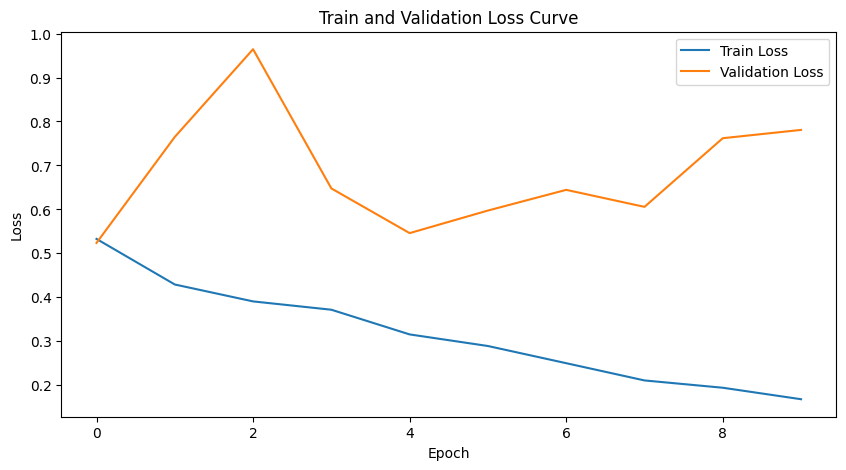

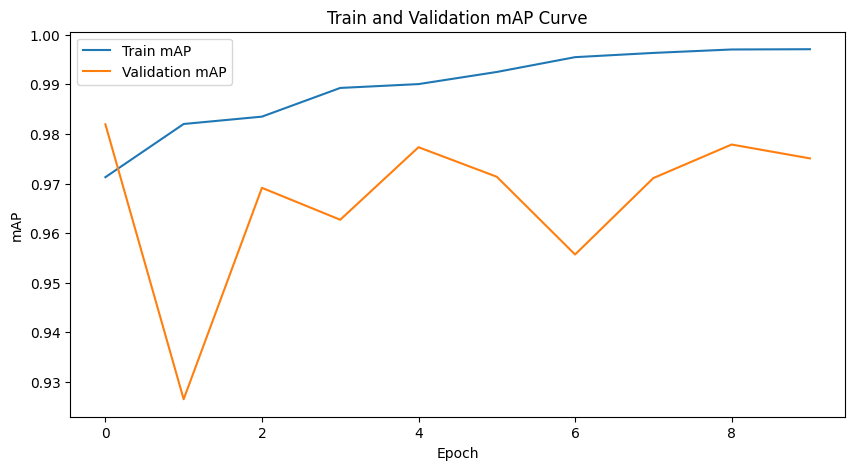

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

# 1. Train/Validation Loss Curve
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss Curve')
    plt.legend()
    plt.show()

# 2. Train/Validation mAP Curve
def plot_map_curve(train_mAPs, val_mAPs):
    plt.figure(figsize=(10, 5))
    plt.plot(train_mAPs, label='Train mAP')
    plt.plot(val_mAPs, label='Validation mAP')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('Train and Validation mAP Curve')
    plt.legend()
    plt.show()

# 3. Confusion Matrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

# 4. PR Curve
def plot_pr_curve(true_labels, predictions_prob):
    precision, recall, _ = precision_recall_curve(true_labels, predictions_prob)
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

#train_losses, train_mAPs, val_losses, val_mAPs
#all_train_labels, all_train_probs, all_val_labels, all_val_probs, best_model_weights
plot_loss_curve(train_losses, val_losses)
plot_map_curve(train_mAPs, val_mAPs)


#test.py


In [16]:

def inference(model, test_loader, device):
    model.eval()
    model_pred = []          # 이진 예측값 저장
    predictions_prob = []    # 예측 확률 저장
    true_labels = []         # 실제 레이블 저장 (테스트 데이터에 레이블이 있는 경우)
    samples = []             # (이미지, 예측 값, 예측 확률) 튜플 저장

    with torch.no_grad():
        for data in tqdm(iter(test_loader)):
            # 데이터가 (이미지, 라벨) 또는 (이미지,) 형식일 경우 첫 번째 요소를 이미지로 간주
            if isinstance(data, (list, tuple)):
                img = data[0]  # 첫 번째 요소를 이미지 텐서로 사용
                if len(data) > 1:
                    true_labels += data[1].cpu().numpy().tolist()  # 실제 레이블 저장
            else:
                img = data

            img = img.float().to(device)
            pred = model(img)

            # Sigmoid로 확률 변환 후, 0.5 기준으로 이진 분류 예측
            prob = pred.sigmoid().detach().cpu().numpy().flatten()  # 예측 확률 저장
            predictions_prob.extend(prob)
            class_pred = (prob > 0.5).astype(int).tolist()          # 예측 클래스로 변환
            model_pred.extend(class_pred)

            # 이미지와 예측 정보 샘플 저장 (테스트 시각화용)
            for image, prediction, probability in zip(img.cpu(), class_pred, prob):
                samples.append((image, prediction, probability))

    return model_pred, predictions_prob, true_labels, samples


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-17-85f459999e0c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

f1 score:  [0.88965517 0.89042278 0.88946459 0.89023336 0.89100346 0.89177489
 0.89254766 0.89332177 0.89409722 0.89487402 0.89565217 0.89643168
 0.89721254 0.89799477 0.89877836 0.89956332 0.90034965 0.90113736
 0.90192644 0.90271691 0.90350877 0.90430202 0.90509666 0.9058927
 0.90669014 0.90748899 0.90828924 0.90909091 0.90989399 0.9106985
 0.91150442 0.91231178 0.91312057 0.91393079 0.91474245 0.91555556
 0.91637011 0.91718611 0.91800357 0.91882248 0.91964286 0.9204647
 0.92128801 0.9221128  0.92293907 0.92376682 0.92459605 0.92542677
 0.92625899 0.92709271 0.92792793 0.92876465 0.92960289 0.93044264
 0.92947559 0.92850679 0.92934783 0.93019039 0.93103448 0.93006358
 0.93090909 0.93175614 0.93260474 0.93345488 0.93430657 0.93515982
 0.93601463 0.936871   0.93772894 0.93858845 0.93944954 0.94031221
 0.94117647 0.94020239 0.94106814 0.94193548 0.94095941 0.94182825
 0.94269871 0.94357077 0.94444444 0.94531974 0.94619666 0.94707521
 0.94795539 0.94697674 0.94785847 0.94874185 0.9496268

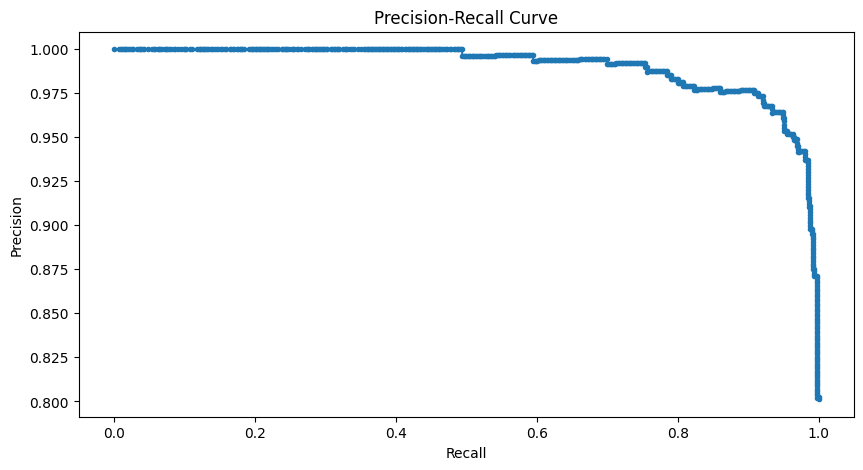

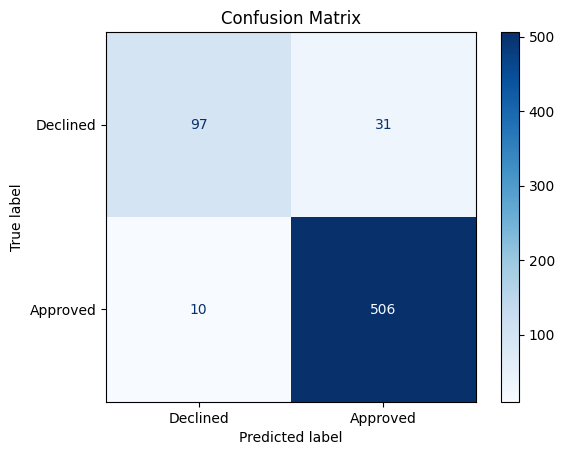

In [17]:
# Seed 고정
seed_everything(42)

model = BaseModel().to(DEVICE)
model.load_state_dict(torch.load('model.pt', map_location=DEVICE))

# 추론 실행
model_pred, predictions_prob, true_labels, samples = inference(model, test_loader, DEVICE)

from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix

precision, recall, thresholds = precision_recall_curve(true_labels, predictions_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

print("f1 score: ", f1_scores)
print("precision: ", precision)
print("recall: ", recall)

# 필요한 시각화 및 후처리
# 예시로 PR Curve와 Confusion Matrix를 그립니다.
plot_pr_curve(true_labels, predictions_prob)
plot_confusion_matrix(true_labels, model_pred, ["Declined", "Approved"])

In [2]:
# Declined 이미지 중에서 False Positive와 False Negative만 필터링하여 시각화
for i, (image, prediction, probability) in enumerate(samples[:30]):
    actual = true_labels[i]  # true_labels 리스트에서 실제 라벨을 가져옴

    # 예측이 Declined인데 실제는 Approved이거나, 예측이 Approved인데 실제는 Declined인 경우만
    if (prediction == 1 and actual == 0) or (prediction == 0 and actual == 1):
        plt.imshow(image.permute(1, 2, 0))  # 이미지 형태 변환
        status = "False Positive" if prediction == 1 else "False Negative"
        plt.title(f"{status}: Prediction: {'Declined' if prediction == 0 else 'Approved'} ({probability:.2f})")
        plt.axis("off")
        plt.show()


NameError: name 'samples' is not defined